In [1]:
from MLimports2 import *
exec(MLimports())


from copy import copy
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from lightgbm import LGBMClassifier as LGB
from scipy import stats
from sklearn import metrics,neighbors,preprocessing
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.me

ImportError: DLL load failed: The specified procedure could not be found.

# Variable threshold classification for SF data set

In [2]:
X,Y = getBFS(part=[0,-1],dataset='sf')

In [ ]:
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from rsc import *

In [ ]:
# Lodaing regression model configurations

OPTIMIZER=[]
OPTIMIZER.append({'name':'XGB','instance':XGBClassifier,'param':{
            'learning_rate' : np.log(np.linspace(1.0001,2,50000)),#np.linspace(0.00001,0.9999,10000), 
            'n_estimators' : range(20,200,1),'objective':['reg:squarederror'],
            'max_depth':range(2,15,1), ##MAR: start at 3 
            'subsample':np.linspace(0.25, 1.0 ,10000),'colsample_bytree': np.linspace(0.01,0.9999,10000),
            'min_child_weight':np.arange(2,15),'n_jobs':[1],
            'gamma':np.linspace(0,50,1000),
            'reg_alpha':np.arange(0,15),'reg_lambda':np.arange(0,15)
}})

OPTIMIZER.append({'name':'LR','instance': LogisticRegression, 'param':{
    'C':np.linspace(0.001,10,10000), 'max_iter': [100,200,500], 'class_weight':[None,'balanced'], 'fit_intercept':[True,False]
}})

OPTIMIZER.append({'name':'LGBM','instance':lgb.LGBMClassifier,'param':{
            'feature_fraction':np.linspace(0.5,1,100),'bagging_fraction':np.linspace(0.5,1,100),'n_jobs':[1],
            'learning_rate' : np.linspace(0.00001,1,10000), 'lambda_l1':np.linspace(0,5,1000),'lambda_l2':np.linspace(0,5,1000),
            'max_depth' : np.arange(2,15), 'metric':['MAE','RMSE'],'objective':['huber', 'gamma', 'fair', 'tweedie'],
            'num_leaves':np.arange(2,31),'verbosity':[-2]
        }})

OPTIMIZER.append({'name':'GBDT','instance': GradientBoostingClassifier, 'param':{
    'learning_rate' : np.linspace(0.00001,1,10000), 
    'n_estimators' : range(20,200,1),
    'max_depth':range(2,15,1), ##MAR: start at 3 
    'subsample':np.linspace(0.25, 1.0 ,10000), 'min_samples_split':np.linspace(0.001,0.999,1000)
}})

OPTIMIZER.append({'name':'KNN','instance':KNeighborsClassifier,'param':{
            'n_neighbors' : range(2,100), 
            'weights' : ['uniform','distance'],
            'p':[1,2], 'leaf_size': np.arange(2,60)
        }})

OPTIMIZER.append({'name':'RF','instance': RandomForestClassifier, 'param':{
    'n_estimators' : range(20,200,1),
    'max_depth':range(2,15,1), ##MAR: start at 3 
}})

In [ ]:
RESULTS=[]

# Iterating over incident duration thresholds to perform binary classification
for TH in np.arange(20,71,5):
    print(TH)
    for O in OPTIMIZER:
        X,Y = getBFS(part=[0,-1],dataset='sf',threshold=TH)

        quantize(X)

        res = RandomSearchC(X,Y,model=O['instance'],params=O['param'],iters=260,jobs=50,TH=45,
                            transform='None',scenario='None',extra=False,OR='None')

        for M in RSOPTIONS['used_metrics']:
            upd = RSeval(res['best_metric_'+M][1])
            upd.update({'Metric':M})
            upd.update({'Model':O['name']})
            upd.update({'Threshold [min]':TH})
            upd.update({'Perc':sum(Y==0)/len(Y)})
            RESULTS.append(upd)
RES=pd.DataFrame(RESULTS)

In [ ]:
import seaborn as sns

sns.set_style("ticks")
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(9,5))
ax = sns.barplot(x="Threshold [min]", y='F1',hue='Model', data=RES)
plt.setp(ax.get_legend().get_texts(), fontsize='13')
plt.tight_layout()
plt.ylim(0,1.1)
plt.yticks(np.linspace(0,1,11))
ax.set_yticks(np.linspace(0,1,11), minor=True)
plt.grid(which='minor')

plt.legend(loc='lower right')
for i, v in enumerate(np.arange(20,71,5)):        
    ax.text(i-0.25 ,RES[RES['Threshold [min]']==v]['F1'].max()+0.025, "{}%".format(int(np.round((1-RES[RES['Threshold [min]']==v]['Perc'].max())*100,0))), color='red', size=14,va ='bottom', rotation=90)

plt.savefig('Xclassif_SF.pdf',format='pdf',bbox_inches='tight',pad_inches = 0)

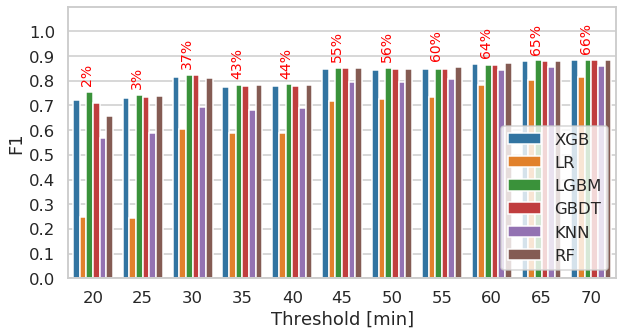

# Outlier removal

In [ ]:
RESULTS=[]
from sklearn.preprocessing import binarize
X,Y = getBFS(part=[0,-1],dataset='sf',threshold=45)
TOTAL=len(Y)

# Removing potential outliers 
# Binary classification by selected threshold (45 min)
for TH in [[0],[29],[360],[29,360]]:
    print(TH)
    for O in OPTIMIZER:
        X,Y = getBFS(part=[0,-1],dataset='sf')
        
        for t in TH:
            X=X[Y!=t]
            Y=Y[Y!=t]
        
        Y = 1-binarize(Y.reshape(-1,1),threshold=45, copy=True).ravel()
        
        quantize(X)

        res = RandomSearchC(X,Y,model=O['instance'],params=O['param'],iters=250,jobs=56,TH=45,
                            transform='None',scenario=';lk',extra=False,OR='None')

        for M in RSOPTIONS['used_metrics']:
            upd = RSeval(res['best_metric_'+M][1])
            upd.update({'Metric':M})
            upd.update({'Model':O['name']})
            upd.update({'LDO Threshold [min]':TH})
            upd.update({'BeforeOR':TOTAL})
            upd.update({'AfterOR':len(Y)})
            RESULTS.append(upd)
RES=pd.DataFrame(RESULTS)

In [90]:
# Cosmetic processing
RES['LDO Threshold [min]'] = RES['LDO Threshold [min]'].apply(lambda v: str(v))
RES['Outlier removed [min]'] = RES['LDO Threshold [min]']
RES.iloc[:6]['Outlier removed [min]']='-'

-
[29]
[360]
[29, 360]


/home/agrigore/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


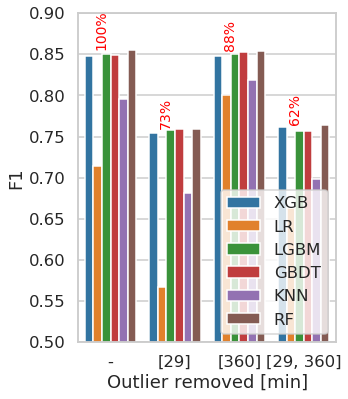

In [101]:
import seaborn as sns

sns.set_style("ticks")
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(5,5.8))
ax = sns.barplot(x="Outlier removed [min]", y='F1',hue='Model', data=RES)
plt.setp(ax.get_legend().get_texts(), fontsize='13')
plt.tight_layout()
plt.ylim(0.5,0.9)
# plt.yticks(np.linspace(0,1,11))
# ax.set_yticks(np.linspace(0,1,11), minor=False)
# ax.set_yticks(np.linspace(0,1,11), minor=True)
plt.grid(which='minor')

plt.legend(loc='lower right')
for i, v in enumerate(['-',[29],[360],[29,360]]): 
    PART = RES[RES['Outlier removed [min]']==str(v)]
    print(v)
    PART['Perc'] = PART['AfterOR']/PART['BeforeOR']
    
    p = int(np.round((PART['Perc'].min())*100,0))
#     ax.text(i-0.25 ,RES[RES['LDO Threshold [min]']==v]['F1'].max()+0.025, "{}%".format(int(np.round((1-RES[RES['LDO Threshold [min]']==v]['Perc'].max())*100,0))), color='red', size=14,va ='bottom', rotation=90)
    ax.text(i-0.25 ,PART['F1'].max(), "{}%".format(p), color='red', size=14,va ='bottom', rotation=90)

plt.savefig('Xor_SF.pdf',format='pdf',bbox_inches='tight',pad_inches = 0)

# San-Francisco, regression residuals (<40min)

In [16]:
X,Y = getBFS(part=[0,40],dataset='sf')
# Y=np.log1p(Y)

In [17]:
cnd = X.monthidx >= (X.monthidx.max()-10)

Xtr = X[cnd]
Xte = X[~cnd]
Ytr = Y[cnd]
Yte = Y[~cnd]

In [21]:
import tqdm
import multiprocessing

REG = {'name':'XGB','instance':XGBRegressor,'param':{
            'learning_rate' : np.log(np.linspace(1.0001,2,50000)),#np.linspace(0.00001,0.9999,10000), 
            'n_estimators' : range(20,200,1),'objective':['reg:squarederror'],
            'max_depth':range(2,15,1), ##MAR: start at 3 
            'subsample':np.linspace(0.25, 1.0 ,10000),'colsample_bytree': np.linspace(0.01,0.9999,10000),
            'min_child_weight':np.arange(2,15),'n_jobs':[1],
#             'gamma':np.linspace(0,50,1000),
#             'reg_alpha':np.arange(0,15),'reg_lambda':np.arange(0,15)
}}

search = RandomizedSearchCV(estimator = REG['instance'](),
                   param_distributions=REG['param'],
                   n_iter=350,
                   scoring=make_scorer(mape, greater_is_better=False),
                   n_jobs=multiprocessing.cpu_count(), ## MAR: used to be 1
                   cv = 10,
                   verbose = 1
                       )
search.fit(Xtr, Ytr)
print(search.best_params_)

Fitting 10 folds for each of 350 candidates, totalling 3500 fits


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=56)]: Done 1016 tasks      | elapsed:    1.8s
[Parallel(n_jobs=56)]: Done 2416 tasks      | elapsed:    3.8s


{'subsample': 0.9564956495649566, 'objective': 'reg:squarederror', 'n_jobs': 1, 'n_estimators': 84, 'min_child_weight': 14, 'max_depth': 12, 'learning_rate': 0.07873119041286854, 'colsample_bytree': 0.7649732373237323}


[Parallel(n_jobs=56)]: Done 3500 out of 3500 | elapsed:    6.0s finished
/home/agrigore/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [22]:
reg = REG['instance'](**search.best_params_)
    
reg.fit(Xtr, Ytr)
pred = np.array(reg.predict(Xte)).ravel()
# pred=np.expm1(pred)

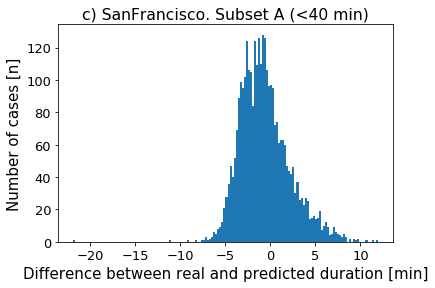

In [23]:
plt.rcParams.update({'font.size': 13})
import matplotlib 
plt.rc('axes', labelsize=15)

plt.hist(Yte-pred,bins=150)
plt.ylabel('Number of cases [n]')
plt.xlabel('Difference between real and predicted duration [min]')
plt.title('c) SanFrancisco. Subset A (<40 min)') #subsetA
plt.savefig('sfresid.pdf',format='pdf')